Reproduce Fig2 

Here I have number of units that are close to the paper (I think because I did a mistake first in calculating constraints - using whole baseline instead of only 1500 ms?)

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
from calculate_tau import fit_single_exp, func_single_exp_monkey
os.chdir(current_wd)

### Get the data

In [2]:
results_folder = project_folder_path + 'results\\monkey\\lab_meeting_snapshot\\fixation_period_1000ms\\'

pfdl_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\acf\\z\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')
pfp_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\acf\\z\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')

print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_pearsonr_df), len(pfp_acf_average_trial_pearsonr_df)))

print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_pearsonr_df.isnull().any().any()))
print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_pearsonr_df.isnull().any().any()))

N neurons in PFdl 367 
N neurons in PFp 318
NaNs in PFdl acf False
NaNs in PFp acf False


In [3]:
pfdl_acf_average_trial_pearsonr_df.head(2)

,unit_id,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,acf_8,...,acf_10,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19
0,0,1.0,0.443787,0.429808,0.374760,0.333984,0.287734,0.240484,0.189922,0.194006,...,0.192847,0.148964,0.216269,0.151006,0.159405,0.112679,0.020760,0.038556,0.046108,-0.052432
1,3,1.0,0.436855,0.391458,0.371095,0.311763,0.294205,0.312247,0.282377,0.260343,...,0.266865,0.243661,0.274786,0.217886,0.234229,0.208189,0.152333,0.194667,0.227410,0.222422


In [4]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

pfdl_acf_2d = pfdl_acf_average_trial_pearsonr_df[acf_cols].values
pfp_acf_2d = pfp_acf_average_trial_pearsonr_df[acf_cols].values

pfdl_acf_mean = np.nanmean(pfdl_acf_2d, axis=0)
pfdl_acf_sem = stats.sem(pfdl_acf_2d, axis=0)
pfp_acf_mean = np.nanmean(pfp_acf_2d, axis=0)
pfp_acf_sem = stats.sem(pfp_acf_2d, axis=0)

### Calculate tau

In [5]:
pfdl_popt, _, pfdl_tau, pfdl_fit_r_squared, _ = fit_single_exp(pfdl_acf_mean, start_idx_=2, exp_fun_=func_single_exp_monkey)
pfdl_tau_ms = pfdl_tau*50
print('pfdl_tau {}, pfdl_popt {}, pfdl_fit_r_squared {}'.format(pfdl_tau_ms, pfdl_popt, pfdl_fit_r_squared))

pfdl_tau 235.90304847805464, pfdl_popt [0.24190483 0.21195148 0.08946648], pfdl_fit_r_squared 0.9975039860068926


In [6]:
pfp_popt, _, pfp_tau, pfp_fit_r_squared, _ = fit_single_exp(pfp_acf_mean, start_idx_=2, exp_fun_=func_single_exp_monkey)
pfp_tau_ms = pfp_tau*50
print('pfp_tau {}, pfp_popt {}, pfp_fit_r_squared {}'.format(pfp_tau_ms, pfp_popt, pfp_fit_r_squared))

pfp_tau 229.3335430571914, pfp_popt [0.19424553 0.21802306 0.10490578], pfp_fit_r_squared 0.9950033078805028


### Plot

In [7]:
save_fig = False
fig_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'

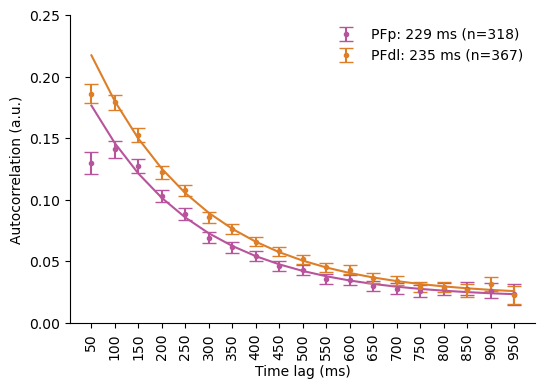

In [8]:
fig, axes = plt.subplots(1,1, figsize=(6,4))

t = np.linspace(1, n_lags-1, n_lags-1).astype(int)
t_labels = np.linspace(50, 950, n_lags-1).astype(int)

pfp_label = 'PFp: ' + str(int(pfp_tau_ms)) + ' ms (n=' + str(len(pfp_acf_average_trial_pearsonr_df)) + ')'
axes.errorbar(t, pfp_acf_mean[1:], pfp_acf_sem[1:], linestyle='None', marker='.', capsize=5, color='#b8549b', label=pfp_label)
axes.plot(t, func_single_exp_monkey(t, pfp_popt[0], pfp_popt[1], pfp_popt[2]), color='#b8549b')

pfdl_label = 'PFdl: ' + str(int(pfdl_tau_ms)) + ' ms (n=' + str(len(pfdl_acf_average_trial_pearsonr_df)) + ')'
axes.errorbar(t, pfdl_acf_mean[1:], pfdl_acf_sem[1:], linestyle='None', marker='.', capsize=5, color='#dd7f28', label=pfdl_label)
axes.plot(t, func_single_exp_monkey(t, pfdl_popt[0], pfdl_popt[1], pfdl_popt[2]), color='#dd7f28', )

axes.set_ylim([0, 0.25])

axes.set_xticks(t)
axes.set_xticklabels(t_labels, rotation=90)
axes.set_xlabel('Time lag (ms)')
axes.set_ylabel('Autocorrelation (a.u.)')  

axes.legend(frameon=False)

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'fig2_repr.png', bbox_inches='tight')
    fig.savefig(fig_folder + 'fig2_repr.svg', bbox_inches='tight')